In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.set_printoptions(linewidth=100)

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
import toml
import pandas
import seaborn
import re
from pathlib import Path
from pprint import pprint

import exot
import exot.experiment
import exot.util
import exot.layer
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

### Setup

In [5]:
PLATFORM_X86 = "Radagast"
PLATFORM_AARCH64 = "Gimli"

RUN=False
RUN_X86=True # is master
RESTORE=True
PLOT=True

In [ ]:
COUNT=250_000
SETS=64

In [ ]:
config =\
{'name': 'Histograms',
 'save_path': './data',
 'backup_path': './data/_backup',
 'experiment_exists_action': 'update',
 'EXPERIMENT': {'type': 'ExploratoryExperiment',
  'channel': 'Cache',
  'PHASES': {},
  'LAYERS': {'io': {'name': 'TimeValue',
    'params': {'synchronise': False, 'timebase': 'ns'}}},
  'GENERAL': {'latency': 10,
   'fan': True,
   'governors': 'userspace',
   'frequencies': 'max',
   'timeout_duration': 50000,
   'sampling_period': 0.001,
   'active_wait': True}},
 'ENVIRONMENTS': {
  PLATFORM_X86: {'APPS': {'src': {'executable': 'utility_cache_hist',
     'zone': 'host'}},
   'src': {'utility': {'self_policy': 'round_robin',
     'self_priority': 99,
     'cpu_to_pin': 0,
     'count': COUNT,
     'sets': SETS},
    'logging': {'log_level': 'debug',
     'provide_platform_identification': True,
     'async': True}}},
  PLATFORM_AARCH64: {'APPS': {'src': {'executable': 'utility_cache_hist',
     'zone': 'combined'}},
   'src': {'utility': {'self_policy': 'round_robin',
     'self_priority': 99,
     'cpu_to_pin': 0,
     'count': COUNT,
     'sets': SETS,
     'measure_with_perf': True},
    'logging': {'log_level': 'debug',
     'provide_platform_identification': True,
     'async': True}}}}}

config["EXPERIMENT"]["PHASES"]["run"] = {}
config["EXPERIMENT"]["PHASES"]["run"]["repetitions"] = 1
config["EXPERIMENT"]["PHASES"]["run"]["rdpstreams"] = [
    pandas.DataFrame({"timestamp": np.arange(0, 5), "value": np.arange(0, 5)})
]

In [ ]:
if not RUN:
    raise RuntimeError("")

In [ ]:
if not RUN:
    raise RuntimeError("")

if RUN_X86:
    channel    = ChannelFactory()(config["EXPERIMENT"]["channel"])
    experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)
    experiment.generate()
    experiment.write()
else:
    experiment = ExploratoryExperiment.read(Path("./data/Histograms/_experiment.pickle"))
    
    experiment.config["EXPERIMENT"]["PHASES"]["run"] = {}
    experiment.config["EXPERIMENT"]["PHASES"]["run"]["repetitions"] = 1
    experiment.config["EXPERIMENT"]["PHASES"]["run"]["rdpstreams"] = [
        pandas.DataFrame({"timestamp": np.arange(0, 5), "value": np.arange(0, 5)})
    ]

In [ ]:
if RUN:
    if RUN_X86:
        experiment.execute_in_environment(PLATFORM_X86, resume=False)
    else:
        experiment.execute_in_environment(PLATFORM_AARCH64, resume=False)
else:
    experiment = ExploratoryExperiment.read(Path("./data/Histograms/_experiment.pickle"))
    experiment.config["EXPERIMENT"]["PHASES"]["run"] = {}
    experiment.config["EXPERIMENT"]["PHASES"]["run"]["repetitions"] = 1
    experiment.config["EXPERIMENT"]["PHASES"]["run"]["rdpstreams"] = [
        pandas.DataFrame({"timestamp": np.arange(0, 5), "value": np.arange(0, 5)})
    ]

In [ ]:
run = experiment.phases['run'][0]
run.parent.layers.io.get_available_environments()

In [ ]:
if RUN_X86:
    experiment.drivers[PLATFORM_X86]["host"].connect()
    tsc_freq_line = experiment.drivers[PLATFORM_X86]["host"].command("dmesg | grep 'Refined TSC'").stdout
    tsc_freq = float(re.findall(r"[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?", tsc_freq_line)[1][0]) * 1e6
    experiment.drivers[PLATFORM_X86]["host"].disconnect()
    
    print("TSC freq:", tsc_freq)
    
    measurements_x86 = run.parent.layers.io.get_logs(env=PLATFORM_X86, app="src", rep=0)
    run.add_intermediate("measurements_x86", measurements_x86)

    measurements_x86['duration'] = measurements_x86['duration'].div(tsc_freq / 1e9)
else:
    log_aarch64 = run.parent.layers.io.get_logs(env=PLATFORM_AARCH64, app="src", rep=0, suffix=".debug.txt")

    aarch64_freqs = {}

    for line in log_aarch64.split("\n"):
        match = re.search(r"cpu: (\d),.+, frequencies: \[(\d+),(\d+)\]", line)
        if match:
            aarch64_freqs[int(match.groups()[0])] = int(match.groups()[2])

    aarch64_freq = aarch64_freqs[experiment.config.ENVIRONMENTS[PLATFORM_AARCH64].src.utility.cpu_to_pin]

    print("aarch64_freq:", aarch64_freq)

    measurements_aarch64 = run.parent.layers.io.get_logs(env=PLATFORM_AARCH64, app="src", rep=0)
    run.add_intermediate("measurements_aarch64", measurements_aarch64)
    measurements_aarch64.head()

    div_all = (
        experiment.config.ENVIRONMENTS[PLATFORM_AARCH64].src.utility.measure_with_perf
        if "measure_with_perf" in experiment.config.ENVIRONMENTS[PLATFORM_AARCH64].src.utility
        else True
    )

    if div_all:
        measurements_aarch64['duration'] /= (aarch64_freq / 1e9)
    else:
        measurements_aarch64.loc[measurements_aarch64["category"] == "access"] = \
            measurements_aarch64.loc[measurements_aarch64["category"] == "access"] / (aarch64_freq / 1e9)

#### Save & restore

In [ ]:
if RUN_X86:
    measurements_x86.to_pickle("measurements_x86.pickle")
else:
    measurements_aarch64.to_pickle("measurements_aarch64.pickle")

In [6]:
if RESTORE:
    measurements_x86 = pandas.read_pickle("measurements_x86.pickle")
    measurements_aarch64 = pandas.read_pickle("measurements_aarch64.pickle")

In [ ]:
# measurements_x86.groupby(["method", "category", "class", "sets"])["duration"].describe()

In [ ]:
# measurements_aarch64.groupby(["method", "category", "class", "sets"])["duration"].describe()

In [ ]:
if not PLOT:
    raise RuntimeError("")

### Histograms

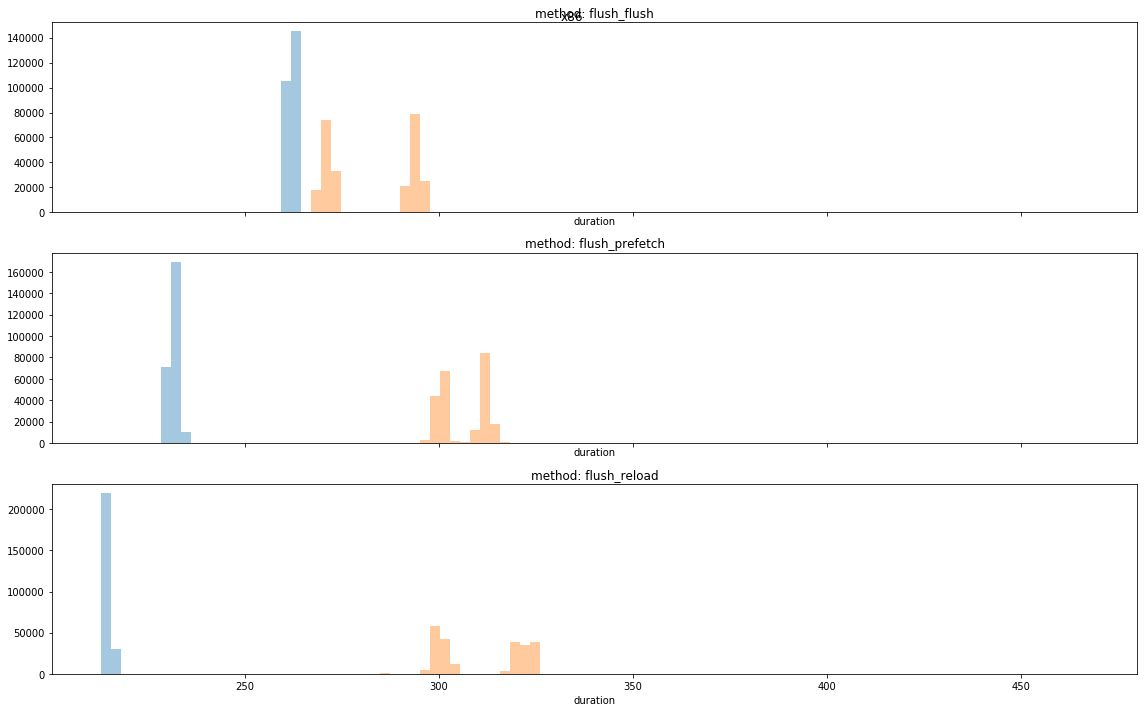

In [9]:
category = "access"
sets = 1

measurements = measurements_x86
methods = ["flush_flush", "flush_prefetch", "flush_reload"] # measurements["method"].unique()
mfilter = (measurements["category"] == category) & (measurements["sets"] == sets)

f, axes = plt.subplots(len(methods), 1, figsize=(16, 10), sharex=True)

limits = np.quantile(measurements.loc[mfilter]["duration"], [0.01, 0.99])
bins = np.linspace(limits[0], limits[1], 100)

for i, method in enumerate(methods):
    hit_data = measurements.loc[mfilter & (measurements["method"] == method) &
                         (measurements["class"] == "hit")]["duration"]
    
    miss_data = measurements.loc[mfilter & (measurements["method"] == method) &
                         (measurements["class"] == "miss")]["duration"]
    
    seaborn.distplot(hit_data, bins=bins, ax=axes[i], kde=False)
    seaborn.distplot(miss_data, bins=bins, ax=axes[i], kde=False)
    axes[i].set_title(f"method: {method}")
        
plt.suptitle("x86")
f.tight_layout()
f.savefig("hist-1-x86.pdf")

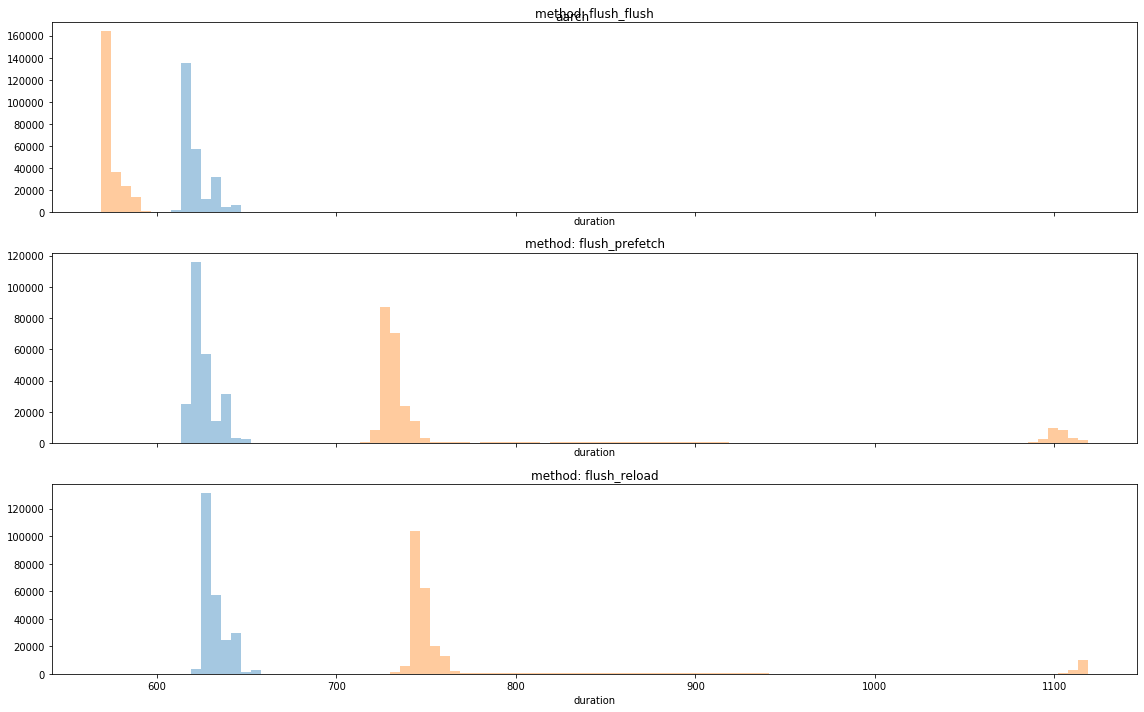

In [12]:
category = "access"
sets = 1

measurements = measurements_aarch64
methods = ["flush_flush", "flush_prefetch", "flush_reload"] # measurements["method"].unique()
mfilter = (measurements["category"] == category) & (measurements["sets"] == sets)

f, axes = plt.subplots(len(methods), 1, figsize=(16, 10), sharex=True)

limits = np.quantile(measurements.loc[mfilter]["duration"], [0.01, 0.99])
bins = np.linspace(limits[0], limits[1], 100)

for i, method in enumerate(methods):
    hit_data = measurements.loc[mfilter & (measurements["method"] == method) &
                         (measurements["class"] == "hit")]["duration"]
    
    miss_data = measurements.loc[mfilter & (measurements["method"] == method) &
                         (measurements["class"] == "miss")]["duration"]
    
    seaborn.distplot(hit_data, bins=bins, ax=axes[i], kde=False)
    seaborn.distplot(miss_data, bins=bins, ax=axes[i], kde=False)
    axes[i].set_title(f"method: {method}")
        
plt.suptitle("aarch")
f.tight_layout()
f.savefig("hist-1-aarch.pdf")

In [ ]:
# PLOT RAW

category = "raw"

measurements = measurements_aarch64
methods = ["flush_flush", "flush_prefetch", "flush_reload"] # measurements["method"].unique()

f, axes = plt.subplots(len(methods), 1, figsize=(16, 10), sharex=True)

limits = np.quantile(measurements.loc[(measurements["category"] == category)]["duration"], [0.01, 0.99])
bins = np.linspace(limits[0], limits[1], 100)

for i, method in enumerate(methods):
    hit_data = measurements.loc[(measurements["method"] == method) &
                         (measurements["category"] == category) &
                         (measurements["class"] == "hit")]["duration"]
    
    miss_data = measurements.loc[(measurements["method"] == method) &
                         (measurements["category"] == category) &
                         (measurements["class"] == "miss")]["duration"]
    
    seaborn.distplot(hit_data, bins=bins, ax=axes[i], kde=False)
    seaborn.distplot(miss_data, bins=bins, ax=axes[i], kde=False)
    axes[i].set_title(f"method: {method}")
        
f.tight_layout()

### Boxplots

TypeError: savefig() takes 2 positional arguments but 3 were given

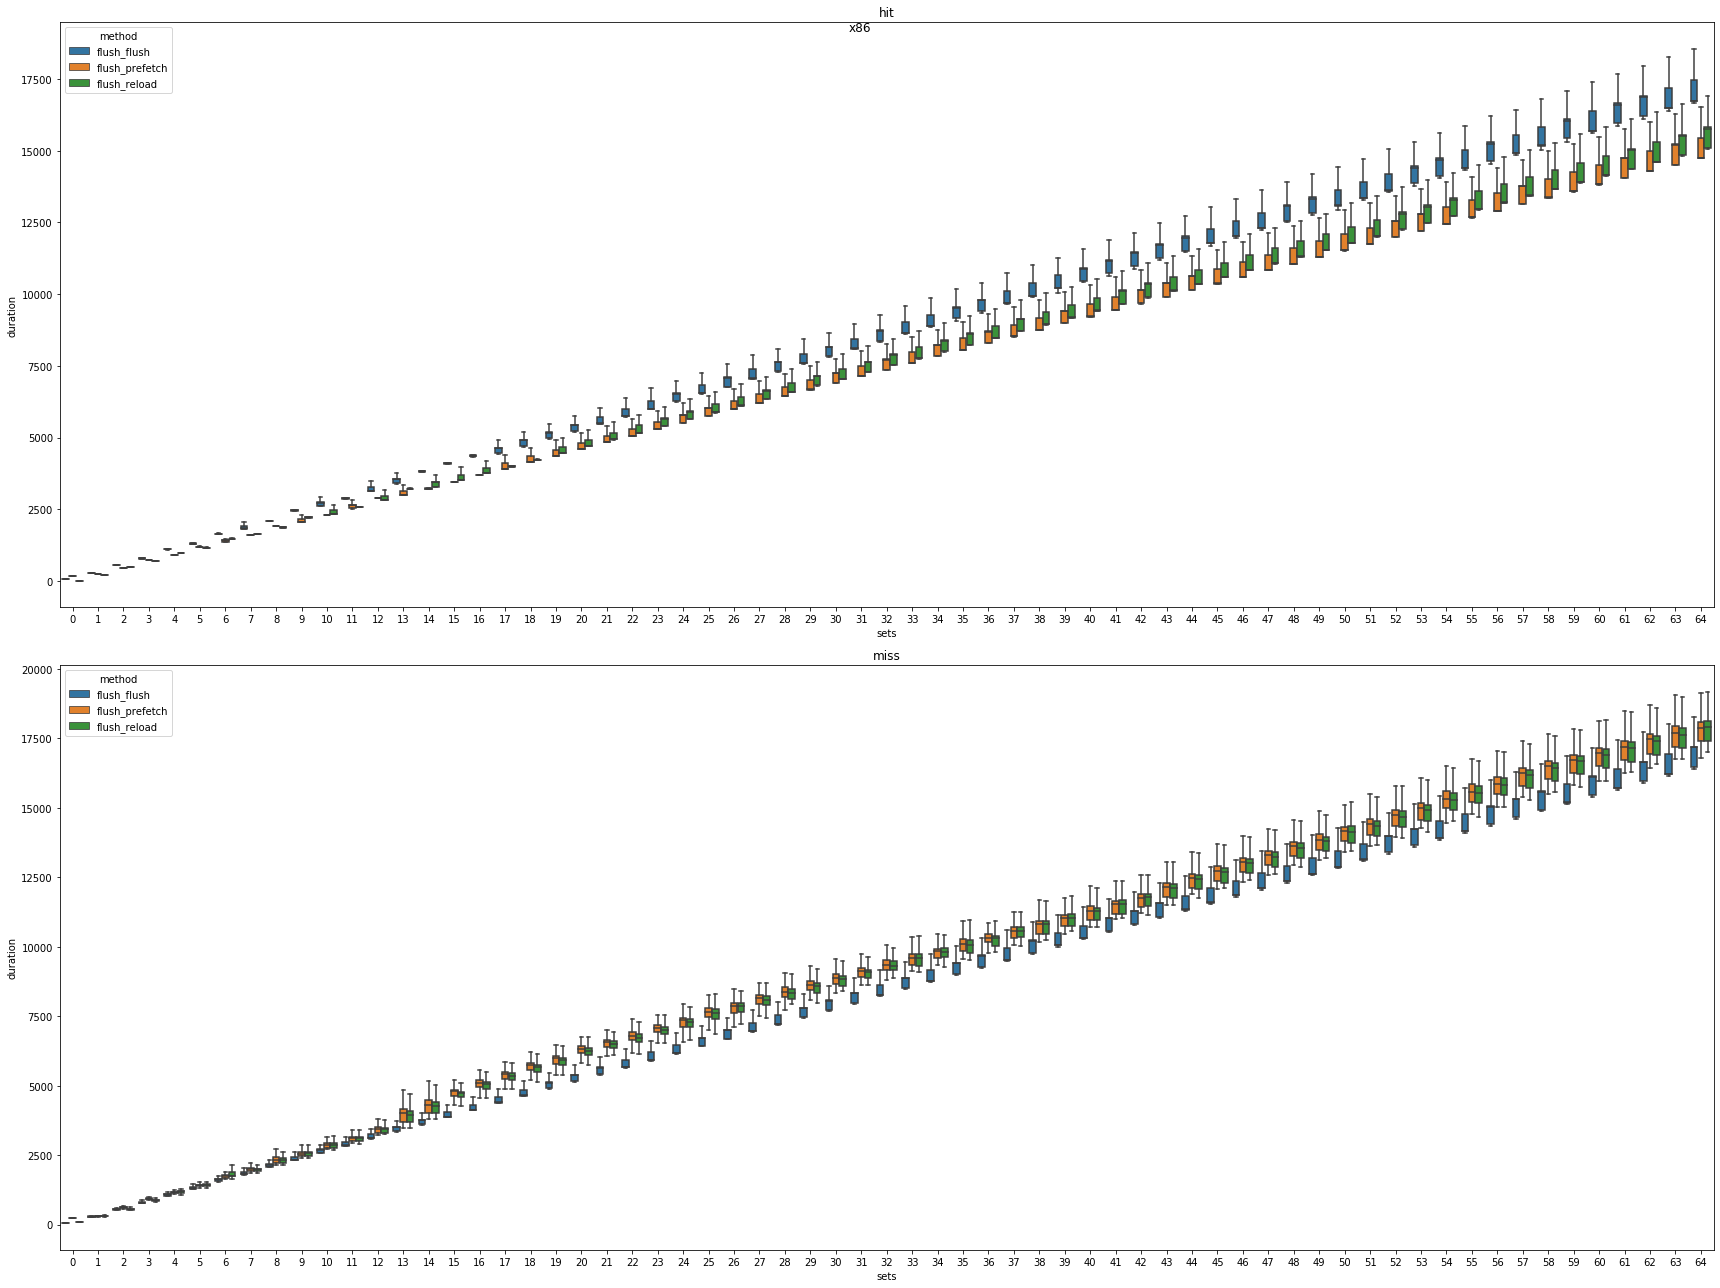

In [15]:
f, axes = plt.subplots(2, 1, figsize=(24, 18))
seaborn.boxplot(x="sets", y="duration", hue="method", showfliers=False,
                data=measurements_x86.loc[measurements_x86["class"] == "hit"], ax=axes[0])
seaborn.boxplot(x="sets", y="duration", hue="method", showfliers=False,
                data=measurements_x86.loc[measurements_x86["class"] == "miss"], ax=axes[1])
axes[0].set_title("hit")
axes[1].set_title("miss")
f.suptitle("x86")
f.tight_layout()
f.savefig("x86-box.pdf")

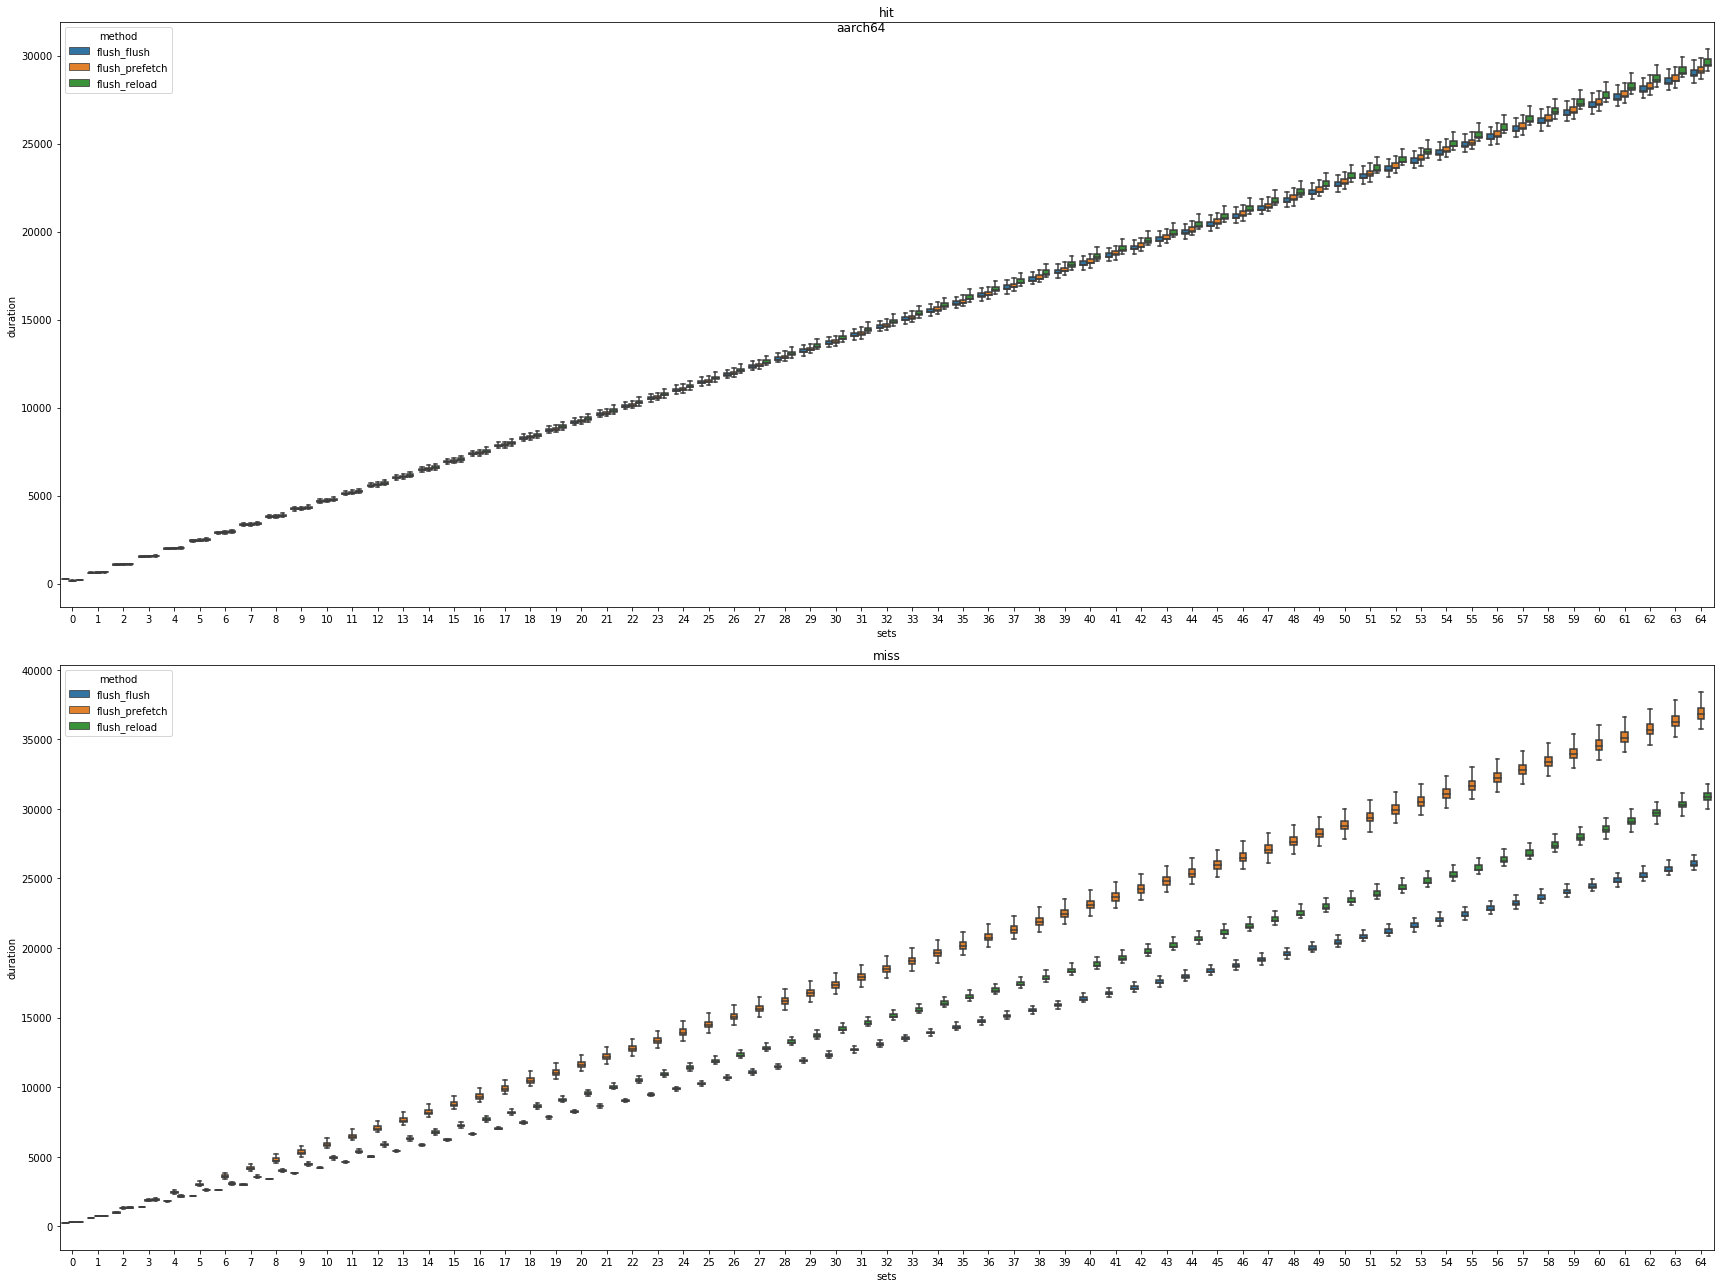

In [18]:
f, axes = plt.subplots(2, 1, figsize=(24, 18))
seaborn.boxplot(x="sets", y="duration", hue="method", showfliers=False,
                data=measurements_aarch64.loc[measurements_aarch64["class"] == "hit"], ax=axes[0])
seaborn.boxplot(x="sets", y="duration", hue="method", showfliers=False,
                data=measurements_aarch64.loc[measurements_aarch64["class"] == "miss"], ax=axes[1])
axes[0].set_title("hit")
axes[1].set_title("miss")
f.suptitle("aarch64")
f.tight_layout()
f.savefig("aarch-box.pdf")